In [14]:
!pip install matplotlib

Firstly, we load the data

In [15]:
import pandas as pd

# Load the dataset from the tweet.csv file
file_path = 'tweets.csv'  
tweets_df = pd.read_csv(file_path)
print(tweets_df.head())


  TweetID User   Latitude   Longitude     Timestamp  \
0      t0   u0  37.737840 -122.864991  1.735501e+09   
1      t1   u0  37.737867 -122.865148  1.735501e+09   
2      t2   u0  37.738150 -122.865172  1.735501e+09   
3      t3   u0  37.737852 -122.864844  1.735501e+09   
4      t4   u0  37.738076 -122.864980  1.735501e+09   

                                  User_home  \
0  [37.73786839040233, -122.86498834096335]   
1  [37.73786839040233, -122.86498834096335]   
2  [37.73786839040233, -122.86498834096335]   
3  [37.73786839040233, -122.86498834096335]   
4  [37.73786839040233, -122.86498834096335]   

                                  User_work  
0  [37.69634301313497, -122.96783829112489]  
1  [37.69634301313497, -122.96783829112489]  
2  [37.69634301313497, -122.96783829112489]  
3  [37.69634301313497, -122.96783829112489]  
4  [37.69634301313497, -122.96783829112489]  


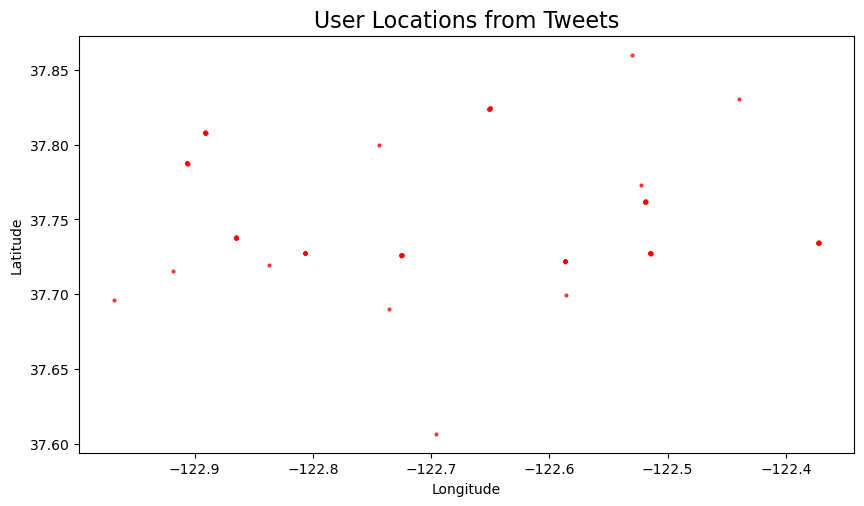

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(tweets_df['Longitude'], tweets_df['Latitude'])]
gdf = gpd.GeoDataFrame(tweets_df, geometry=geometry, crs="EPSG:4326")

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='red', alpha=0.7, markersize=4)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Locations from Tweets', fontsize=16)

plt.show()
